In [1]:
import os
import torch
import numpy as np 
import pandas as pd 
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import time
from IPython.display import clear_output
from torchvision.models import resnet34, ResNet34_Weights

In [2]:
if not os.path.exists("pytorch_unet.py"):
    if not os.path.exists("pytorch_unet"):
        !git clone https://github.com/usuyama/pytorch-unet.git
    %cd pytorch-unet

fatal: destination path 'pytorch-unet' already exists and is not an empty directory.
/kaggle/working/pytorch-unet


In [3]:
if not torch.cuda.is_available():
    raise Exception("GPU not available. CPU training will be too slow.")

print("Device name:", torch.cuda.get_device_name(0))

Device name: Tesla P100-PCIE-16GB


In [4]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in the red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        # Combine file paths for different spectral bands into a dictionary
        files = {'red': r_file, 
                 'green': g_dir / r_file.name.replace('red', 'green'),
                 'blue': b_dir / r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': gt_dir / r_file.name.replace('red', 'gt')}
        return files
        
    def __len__(self):
        # Return the number of files in the dataset
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        # Open image files as arrays, optionally including NIR channel
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))
    
        # Normalize pixel values
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
        
    def open_mask(self, idx, add_dims=False):
        # Open ground truth mask as an array
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        # Get an item from the dataset (image and mask)
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        # Open an image as a PIL image
        arr = 256 * self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s


In [5]:
base_path = Path('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)
data.files[0]

{'red': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_red/red_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'green': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_green/green_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'blue': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_blue/blue_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'nir': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_nir/nir_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF'),
 'gt': PosixPath('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_gt/gt_patch_62_3_by_18_LC08_L1TP_064014_20160420_20170223_01_T1.TIF')}

In [6]:
print(data[2][0].shape, data[2][1].shape)

torch.Size([4, 384, 384]) torch.Size([384, 384])


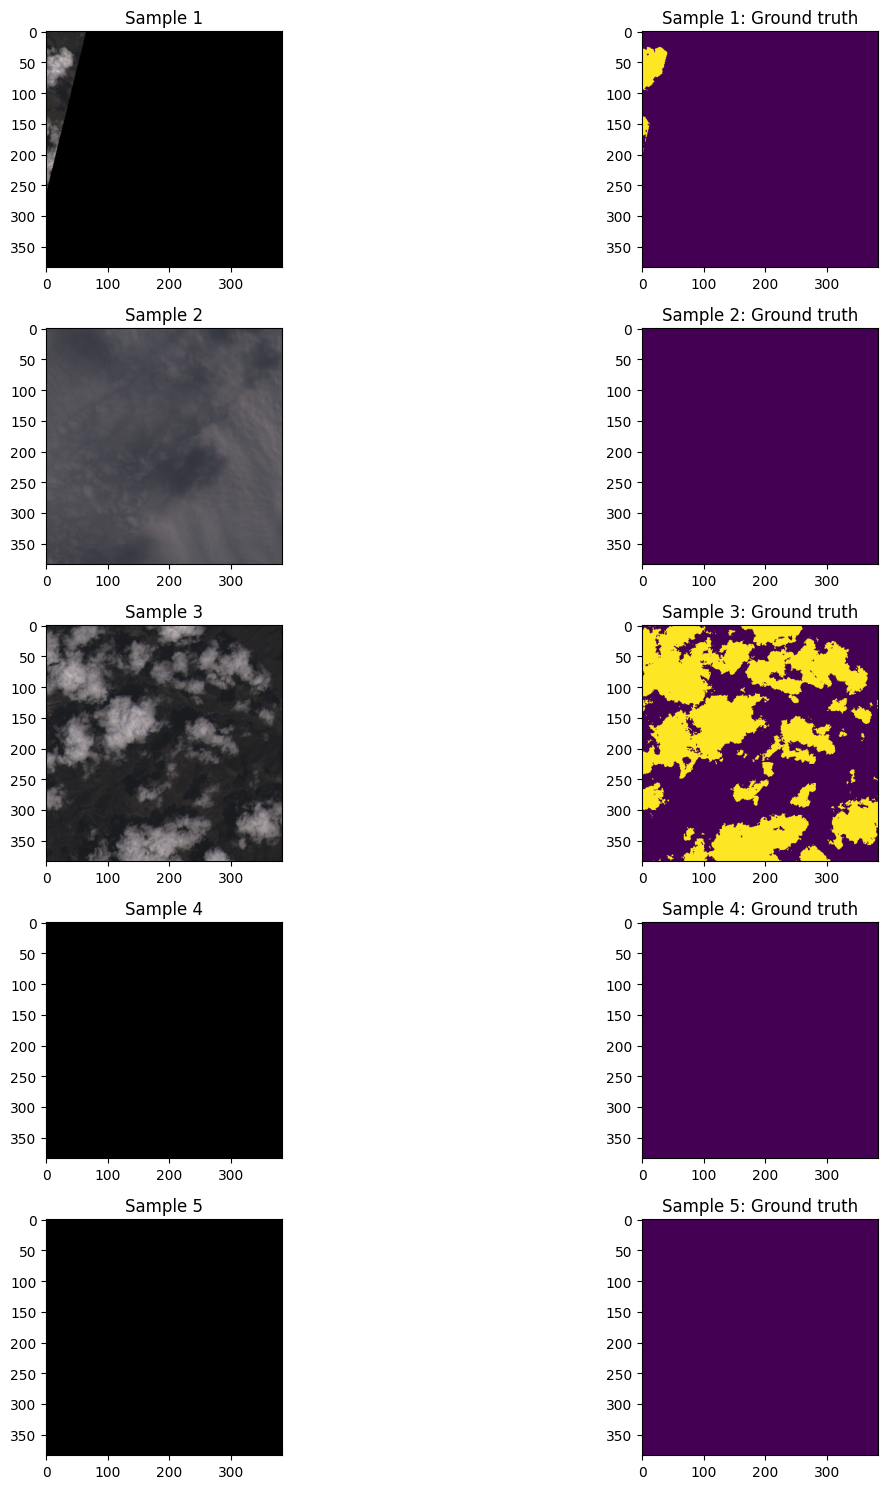

In [7]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

sample_indices = random.sample(range(len(data)), 5)

for i, idx in enumerate(sample_indices):
    ax[i, 0].imshow(data.open_as_array(idx))
    ax[i, 0].set_title(f'Sample {i + 1}')
    
    ax[i, 1].imshow(data.open_mask(idx))
    ax[i, 1].set_title(f'Sample {i + 1}: Ground truth')

plt.tight_layout()
plt.show()

In [8]:
# Split the dataset into training and validation subsets
train_ds, valid_ds = torch.utils.data.random_split(data, (5800, 2600))

# Create a data loader for the training dataset
# - Batch size: 12, meaning each iteration provides a batch of 10 samples
# - Shuffle the data during training to introduce randomness
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)

# Create a data loader for the validation dataset with the same settings as the training loader
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=True)

# Retrieve the next batch of data from the training data loader for inspection
xb, yb = next(iter(train_dl))

# Print the shapes of the input batch (xb) and label batch (yb) tensors
print("Input Batch Shape:", xb.shape)
print("Label Batch Shape:", yb.shape)

Input Batch Shape: torch.Size([10, 4, 384, 384])
Label Batch Shape: torch.Size([10, 384, 384])


# MODELO 1 — Cloud Detection

In [9]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )  

class UNet(nn.Module):

    def __init__(self, n_class, in_channels=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [10]:
model = UNet(2)

print(model)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [11]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([10, 4, 384, 384]), torch.Size([10, 384, 384]))

In [12]:
pred = model(xb)
pred.shape

torch.Size([10, 2, 384, 384])

In [13]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # Modify first layer of ResNet34 to accept custom number of channels
        base_model = resnet34(weights=None)
        base_model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.base_layers = list(base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        
        self.upconv4 = self.expand_block(512, 256)
        self.upconv3 = self.expand_block(256*2, 128)
        self.upconv2 = self.expand_block(128*2, 64)
        self.upconv1 = self.expand_block(64*2, 64)
        self.upconv0 = self.expand_block(64*2, out_channels)
        
    def forward(self, x):

        # Contracting Path
        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        # Expansive Path
        upconv4 = self.upconv4(layer4)
        upconv3 = self.upconv3(torch.cat([upconv4, layer3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, layer2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, layer1], 1))
        upconv0 = self.upconv0(torch.cat([upconv1, layer0], 1))

        return upconv0
        
    def expand_block(self, in_channels, out_channels):
        expand = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )
        return expand

In [14]:
UNET = UNET(4, 2)

In [15]:
pred = UNET(xb)
pred.shape

torch.Size([10, 2, 384, 384])

In [16]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []
    overall_acc = []
    current_acc = 0.0

    best_acc = 0.0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0
            
            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss.detach()*dataloader.batch_size

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            current_acc = (current_acc + epoch_acc)/2
            overall_acc.append(current_acc)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss, overall_acc    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()




In [17]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(UNET.parameters(), lr=0.01)
train_loss, valid_loss, overall_acc = train(UNET, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=10)

Epoch 9/9
----------
valid Loss: 0.1215 Acc: 0.950948178768158
----------
Training complete in 36m 22s


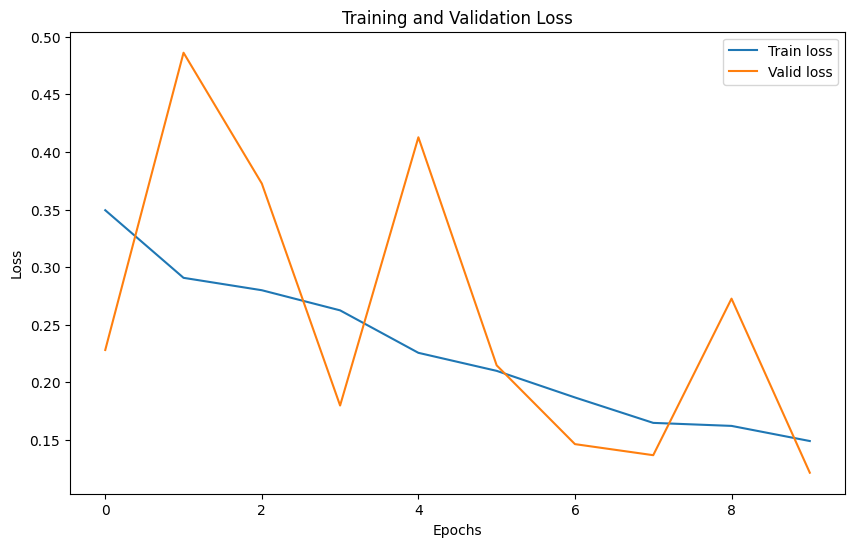

In [19]:
plt.figure(figsize=(10,6))
plt.plot([loss.cpu().item() for loss in train_loss], label='Train loss') 
plt.plot([loss.cpu().item() for loss in valid_loss], label='Valid loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [22]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = UNET(xb.cuda())

predb.shape

torch.Size([10, 2, 384, 384])

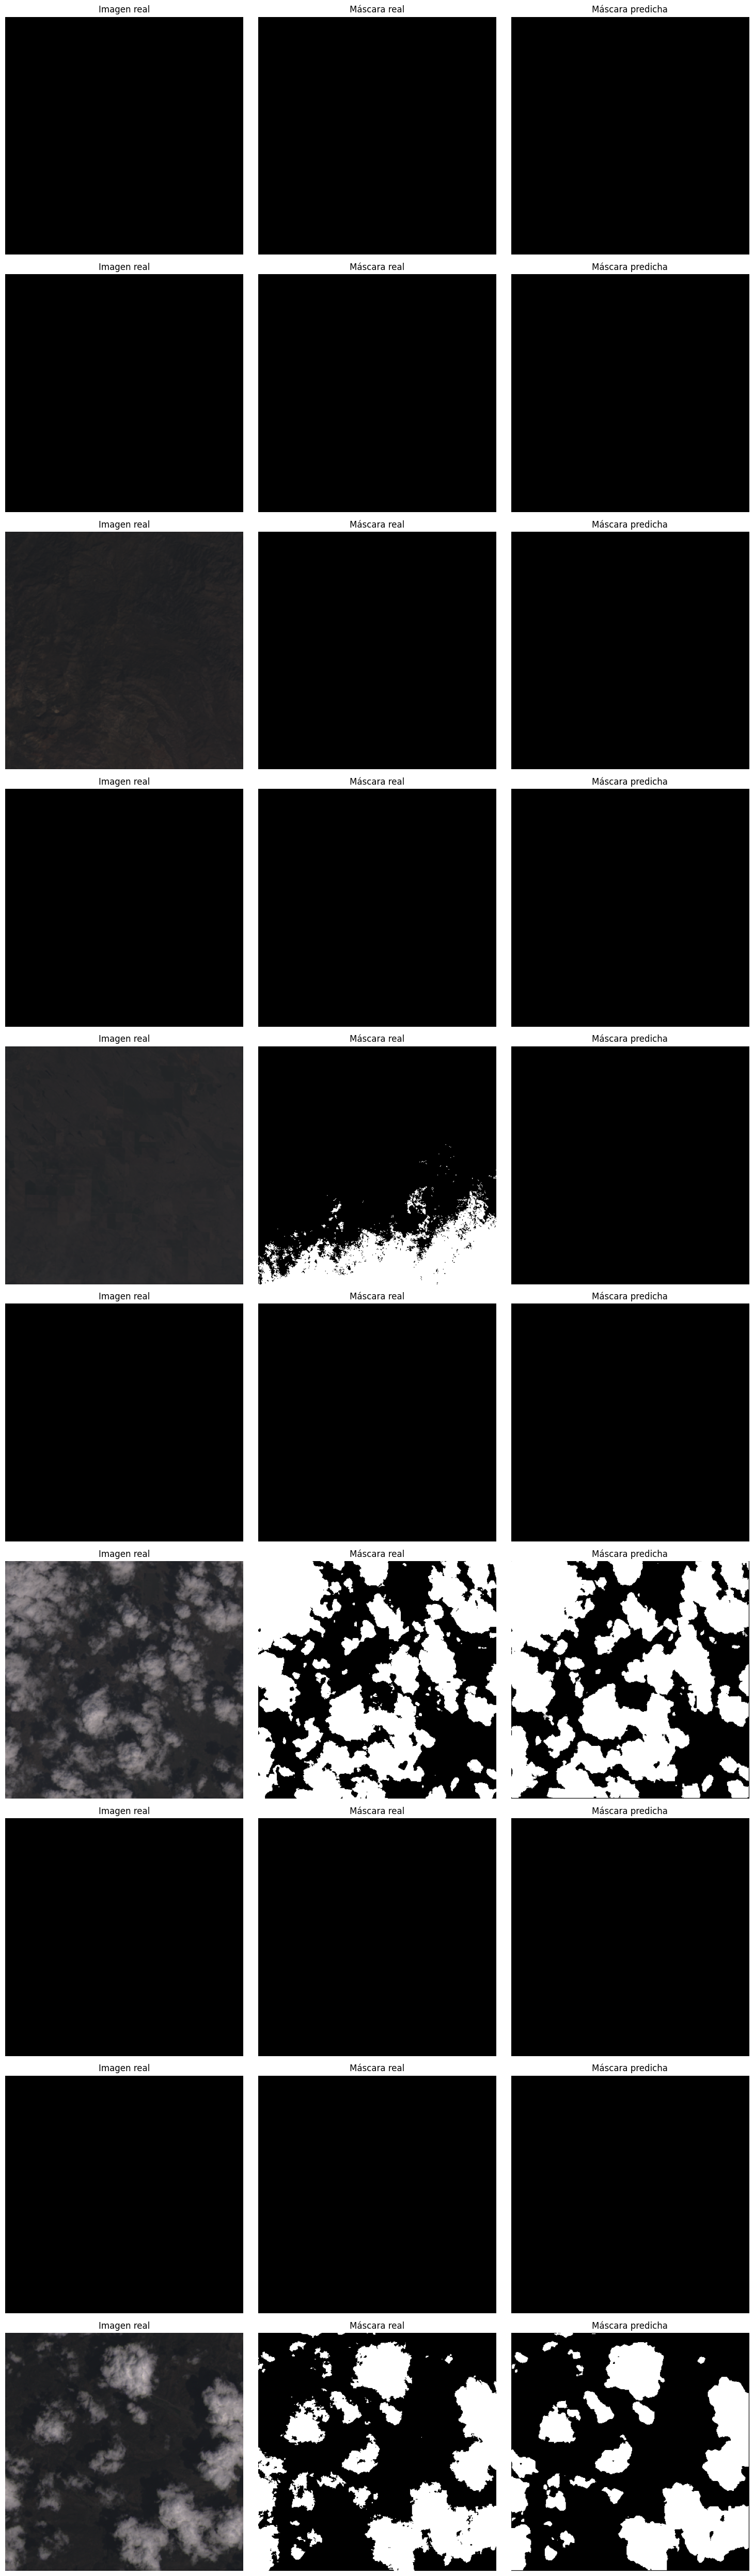

In [23]:
bs = min(10, xb.shape[0])  # 

fig, ax = plt.subplots(bs, 3, figsize=(15, bs * 5))

for i in range(bs):
    # Imagen real
    ax[i, 0].imshow(batch_to_img(xb, i))
    ax[i, 0].set_title("Imagen real")
    ax[i, 0].axis("off")

    # Máscara real (ground truth)
    ax[i, 1].imshow(yb[i].squeeze(), cmap="gray")
    ax[i, 1].set_title("Máscara real")
    ax[i, 1].axis("off")

    # Máscara predicha
    ax[i, 2].imshow(predb_to_mask(predb, i), cmap="gray")
    ax[i, 2].set_title("Máscara predicha")
    ax[i, 2].axis("off")

plt.tight_layout()
plt.show()


In [24]:
torch.save(model.state_dict(), "cloud_segmentation_model_final.pth")



# Modelo 2 Cloud Removal (Inpainting condicional)

In [25]:
gt = data.open_mask(5)
gt.min(), gt.max(), gt.dtype


(np.int64(0), np.int64(1), dtype('int64'))

In [27]:
def is_clean(gt_mask, max_cloud_ratio=0.0):
    """
    gt_mask: uint8, valores {0,1}
    """
    cloud_pixels = (gt_mask == 1).sum()
    total_pixels = gt_mask.size
    cloud_ratio = cloud_pixels / total_pixels
    return cloud_ratio <= max_cloud_ratio


In [28]:
clean_indices = []

for i in range(len(data)):
    gt = data.open_mask(i)
    if is_clean(gt, max_cloud_ratio=0.01):
        clean_indices.append(i)

print(f"Parches limpios: {len(clean_indices)} / {len(data)}")


Parches limpios: 3974 / 8400


In [29]:
def generate_artificial_mask(h, w,
                             min_ratio=0.15,
                             max_ratio=0.4):
    mask = np.zeros((h, w), dtype=np.float32)

    target_area = np.random.uniform(min_ratio, max_ratio) * h * w

    while mask.sum() < target_area:
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        r = np.random.randint(12, 48)

        Y, X = np.ogrid[:h, :w]
        blob = (X - cx)**2 + (Y - cy)**2 <= r**2
        mask[blob] = 1.0

    return mask


In [30]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class CloudInpaintingDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir):
        self.files = [
            {
                'r': f,
                'g': g_dir / f.name.replace('red', 'green'),
                'b': b_dir / f.name.replace('red', 'blue'),
                'nir': nir_dir / f.name.replace('red', 'nir'),
                'gt': gt_dir / f.name.replace('red', 'gt')
            }
            for f in r_dir.iterdir() if not f.is_dir()
        ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # --- Bandas ---
        r = np.array(Image.open(self.files[idx]['r']), dtype=np.float32)
        g = np.array(Image.open(self.files[idx]['g']), dtype=np.float32)
        b = np.array(Image.open(self.files[idx]['b']), dtype=np.float32)
        nir = np.array(Image.open(self.files[idx]['nir']), dtype=np.float32)

        img = np.stack([r, g, b, nir], axis=0)  # (4,H,W)
        img = img / img.max()

        # --- Máscara real (nubes) ---
        hole_mask = np.array(Image.open(self.files[idx]['gt']))
        hole_mask = (hole_mask == 255).astype(np.float32)
        hole_mask = np.expand_dims(hole_mask, axis=0)  # (1,H,W)

        # --- Input con huecos ---
        x = img * (1 - hole_mask)
        x = np.concatenate([x, hole_mask], axis=0)  # (5,H,W)

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(hole_mask, dtype=torch.float32)
        )


In [36]:
# Si data es una instancia de CloudDataset, puedes extraer los paths
dataset = CloudInpaintingDataset(
    r_dir=base_path/'train_red',
    g_dir=base_path/'train_green',
    b_dir=base_path/'train_blue',
    nir_dir=base_path/'train_nir',
    gt_dir=base_path/'train_gt'
)

# Luego filtrar por clean_indices
if clean_indices:
    filtered_files = [dataset.files[i] for i in clean_indices]
    dataset.files = filtered_files

In [38]:

# Luego, obtén una muestra
sample_idx = 0  # o cualquier índice
x_final, x_clean, hole_mask = dataset[sample_idx]

# Extraer RGB para visualización (primeros 3 canales de x_clean)
rgb_clean = x_clean[:3, :, :]  # [3, H, W]
rgb_masked = x_final[:3, :, :]  # [3, H, W] (con huecos)

/tmp/ipykernel_55/3227997571.py:30: RuntimeWarning: invalid value encountered in divide
  img = img / img.max()


In [39]:
def normalize_for_display(img):
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2 + 1e-6), 0, 1)
    return img
x, y, m = dataset[0]


rgb_clean = normalize_for_display(rgb_clean)
rgb_masked = normalize_for_display(rgb_masked)

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(rgb_clean)
plt.title("Imagen limpia (RGB)")

plt.subplot(1,4,2)
plt.imshow(m.numpy(), cmap='gray')
plt.title("Máscara artificial")

plt.subplot(1,4,3)
plt.imshow(rgb_masked)
plt.title("Input RGB con huecos")

plt.subplot(1,4,4)
plt.imshow(x[4].numpy(), cmap='gray')
plt.title("Canal máscara")

plt.show()


/tmp/ipykernel_55/3227997571.py:30: RuntimeWarning: invalid value encountered in divide
  img = img / img.max()


AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
x, y, m = dataset[7]

print(x.shape)  # (5,384,384)
print(y.shape)  # (4,384,384)
print(m.shape)  # (1,384,384)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class PartialConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.input_conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.mask_conv = nn.Conv2d(1, 1, kernel_size, stride, padding, bias=False)

        nn.init.constant_(self.mask_conv.weight, 1.0)
        for p in self.mask_conv.parameters():
            p.requires_grad = False

    def forward(self, x, mask):
        x = x * mask

        out = self.input_conv(x)

        with torch.no_grad():
            mask_out = self.mask_conv(mask)
            mask_sum = mask_out.clone()
            mask_sum[mask_sum == 0] = 1.0

        out = out / mask_sum
        mask_out = (mask_out > 0).float()

        return out, mask_out


In [ ]:
class PConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pconv = PartialConv2d(in_ch, out_ch)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        x, mask = self.pconv(x, mask)
        x = self.bn(x)
        x = self.relu(x)
        return x, mask


In [ ]:
class PConvUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = PConvBlock(4, 64)
        self.enc2 = PConvBlock(64, 128)
        self.enc3 = PConvBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.dec2 = PConvBlock(256 + 128, 128)
        self.dec1 = PConvBlock(128 + 64, 64)

        self.final = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x, hole_mask):
        valid_mask = 1 - hole_mask
        x = x[:, :4]  # quitamos canal máscara

        # Encoder
        e1, m1 = self.enc1(x, valid_mask)
        e2, m2 = self.enc2(self.pool(e1), self.pool(m1))
        e3, m3 = self.enc3(self.pool(e2), self.pool(m2))

        # Decoder
        d2 = F.interpolate(e3, scale_factor=2)
        d2 = torch.cat([d2, e2], dim=1)
        d2, _ = self.dec2(d2, torch.ones_like(m2))

        d1 = F.interpolate(d2, scale_factor=2)
        d1 = torch.cat([d1, e1], dim=1)
        d1, _ = self.dec1(d1, torch.ones_like(m1))

        return self.final(d1)


In [ ]:
from pytorch_msssim import ssim

def masked_l1(pred, gt, mask):
    return torch.mean(torch.abs(pred - gt) * mask)

def masked_ssim(pred, gt, mask):
    return 1 - ssim(pred * mask, gt * mask, data_range=1.0)

def total_loss(pred, gt, hole_mask):
    return masked_l1(pred, gt, hole_mask) + masked_ssim(pred, gt, hole_mask)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PConvUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PConvUNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

for epoch in range(20):
    model.train()
    epoch_loss = 0

    for x, y, m in train_dl:
        x, y, m = x.to(device), y.to(device), m.to(device)

        pred = model(x, m)
        loss = total_loss(pred, y, m)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch}: loss = {epoch_loss / len(train_dl):.4f}")


In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: decoder features
        # x: encoder skip
        psi = self.relu(self.W_g(g) + self.W_x(x))
        psi = self.psi(psi)
        return x * psi


In [ ]:
self.att2 = AttentionGate(F_g=256, F_l=128, F_int=64)
self.att1 = AttentionGate(F_g=128, F_l=64, F_int=32)


In [ ]:
# Decoder nivel 2
d2 = F.interpolate(e3, scale_factor=2)
e2_att = self.att2(d2, e2)
d2 = torch.cat([d2, e2_att], dim=1)
d2, _ = self.dec2(d2, torch.ones_like(m2))

# Decoder nivel 1
d1 = F.interpolate(d2, scale_factor=2)
e1_att = self.att1(d1, e1)
d1 = torch.cat([d1, e1_att], dim=1)
d1, _ = self.dec1(d1, torch.ones_like(m1))


In [ ]:
def spectral_constraint(pred):
    nir = pred[:, 3:4]
    rgb_mean = pred[:, :3].mean(dim=1, keepdim=True)
    return torch.mean(torch.abs(nir - rgb_mean))


In [ ]:
loss = masked_l1 + masked_ssim + 0.05 * spectral_constraint(pred)


In [ ]:
with torch.no_grad():
    sample_x, sample_y, sample_m = dataset[42]
    sample_x = sample_x.unsqueeze(0).to(device)

    pred = model(sample_x, sample_m.unsqueeze(0).to(device))

    save_image(
        torch.cat([sample_x[:, :3], pred[:, :3]], dim=0),
        f"epoch_{epoch}.png"
    )


In [ ]:
def SAM(pred, gt):
    num = torch.sum(pred * gt, dim=1)
    den = torch.norm(pred, dim=1) * torch.norm(gt, dim=1)
    return torch.mean(torch.acos(num / (den + 1e-6)))


In [ ]:
def spectral_rmse(pred, gt):
    return torch.sqrt(torch.mean((pred - gt) ** 2))


In [ ]:
# cloud_inpainting_fix.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# (Opcional) ssim de pytorch_msssim. Instalar si es necesario: pip install pytorch-msssim
try:
    from pytorch_msssim import ssim
except Exception:
    ssim = None
    print("Aviso: pytorch_msssim no disponible. masked_ssim usará fallback (0).")

# -------------------------
# Utilidades y funciones
# -------------------------
def is_clean(gt_mask, max_cloud_ratio=0.0):
    """
    gt_mask: numpy array con valores {0,1} o {0,255}
    Retorna True si la proporción de nubes <= max_cloud_ratio
    """
    # Aseguramos binario 0/1
    gm = (gt_mask == 255) | (gt_mask == 1)
    cloud_pixels = np.count_nonzero(gm)
    total_pixels = gt_mask.size
    cloud_ratio = cloud_pixels / float(total_pixels)
    return cloud_ratio <= max_cloud_ratio

def generate_artificial_mask(h, w, min_ratio=0.15, max_ratio=0.4):
    mask = np.zeros((h, w), dtype=np.float32)
    target_area = np.random.uniform(min_ratio, max_ratio) * h * w
    while mask.sum() < target_area:
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        r = np.random.randint(12, 48)
        Y, X = np.ogrid[:h, :w]
        blob = (X - cx)**2 + (Y - cy)**2 <= r**2
        mask[blob] = 1.0
    return mask.astype(np.float32)

def normalize_for_display(img):
    img = img.astype(np.float32)
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2 + 1e-6), 0, 1)
    return img

def tensor_to_rgb_numpy(t):
    """
    t: tensor (C,H,W) with C>=3, values en [0,1] o [0,255]
    devuelve HxWx3 numpy float en [0,1]
    """
    arr = t.cpu().numpy()
    rgb = arr[:3]  # (3,H,W)
    rgb = np.transpose(rgb, (1,2,0))  # H,W,3
    # Si valores mayores que 1, asumimos quedan en 0-255
    if rgb.max() > 1.0:
        rgb = rgb / 255.0
    rgb = np.clip(rgb, 0, 1)
    return rgb

# -------------------------
# Dataset
# -------------------------
class CloudInpaintingDataset(Dataset):
    def __init__(self, r_dir: Path, g_dir: Path, b_dir: Path, nir_dir: Path, gt_dir: Path):
        # Construyo lista de ficheros a partir de r_dir (asumo nombres coherentes)
        self.files = []
        for f in r_dir.iterdir():
            if f.is_dir(): 
                continue
            # reemplazos simples: ajustar si tus nombres no siguen esta convención
            g = g_dir / f.name.replace('red', 'green')
            b = b_dir / f.name.replace('red', 'blue')
            nir = nir_dir / f.name.replace('red', 'nir')
            gt = gt_dir / f.name.replace('red', 'gt')
            # Nos aseguramos de que existan los archivos (si no, omitimos)
            if g.exists() and b.exists() and nir.exists() and gt.exists():
                self.files.append({'r': f, 'g': g, 'b': b, 'nir': nir, 'gt': gt})
        if len(self.files) == 0:
            raise ValueError("No se encontraron archivos en los directorios indicados (revisa nombres y paths).")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        entry = self.files[idx]
        # Abrir como L (grises) para las bandas si las imágenes son single-channel.
        # Si tus tifs son multi-channel ajusta .convert(...) según necesidad.
        r = np.array(Image.open(entry['r']).convert('F'), dtype=np.float32)  # 'F' para float
        g = np.array(Image.open(entry['g']).convert('F'), dtype=np.float32)
        b = np.array(Image.open(entry['b']).convert('F'), dtype=np.float32)
        nir = np.array(Image.open(entry['nir']).convert('F'), dtype=np.float32)

        # Normalización robusta: si sabemos que es 0-255 usar /255.0. Aquí usamos auto:
        maxv = max(r.max(), g.max(), b.max(), nir.max(), 1.0)
        img = np.stack([r, g, b, nir], axis=0) / (maxv + 1e-6)  # (4,H,W)

        # Máscara GT: la abrimos en L y la binarizamos (0/1)
        hole_mask = np.array(Image.open(entry['gt']).convert('L'), dtype=np.uint8)
        # Asumimos que las nubes están en 255
        hole_mask = (hole_mask == 255).astype(np.float32)
        hole_mask = np.expand_dims(hole_mask, axis=0)  # (1,H,W)

        # Input con huecos: concatenamos imagen con canal máscara
        x = img * (1.0 - hole_mask)  # huecos en canales
        x = np.concatenate([x, hole_mask], axis=0).astype(np.float32)  # (5,H,W)

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(hole_mask, dtype=torch.float32)
        )

# -------------------------
# Partial Conv layers
# -------------------------
class PartialConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.input_conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        # mask_conv produce una salida de 1 canal (suma de valores del patch de la máscara)
        self.mask_conv = nn.Conv2d(1, 1, kernel_size, stride, padding, bias=False)
        nn.init.constant_(self.mask_conv.weight, 1.0)
        for p in self.mask_conv.parameters():
            p.requires_grad = False

    def forward(self, x, mask):
        # x: (B,C,H,W), mask: (B,1,H,W) con 0/1
        x_masked = x * mask  # broadcasting en C
        out = self.input_conv(x_masked)  # (B,out_ch,H,W)

        with torch.no_grad():
            mask_out = self.mask_conv(mask)  # (B,1,H,W)
            mask_sum = mask_out.clone()
            mask_sum[mask_sum == 0] = 1.0  # para evitar división por cero

        # Divido cada canal por la cantidad valida en el parche
        out = out / mask_sum  # broadcasting sobre canales
        mask_out = (mask_out > 0).float()
        return out, mask_out

class PConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pconv = PartialConv2d(in_ch, out_ch)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        x, mask = self.pconv(x, mask)
        x = self.bn(x)
        x = self.relu(x)
        return x, mask

# -------------------------
# Attention Gate (para skip connections)
# -------------------------
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, kernel_size=1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        psi = self.psi(psi)
        return x * psi

# -------------------------
# PConv U-Net con Attention
# -------------------------
class PConvUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoders
        self.enc1 = PConvBlock(4, 64)
        self.enc2 = PConvBlock(64, 128)
        self.enc3 = PConvBlock(128, 256)
        self.pool = nn.MaxPool2d(2)

        # Attention gates
        self.att2 = AttentionGate(F_g=256, F_l=128, F_int=64)
        self.att1 = AttentionGate(F_g=128, F_l=64, F_int=32)

        # Decoders (not exactamente PConv tradicionales pero adaptado)
        self.dec2 = PConvBlock(256 + 128, 128)
        self.dec1 = PConvBlock(128 + 64, 64)

        self.final = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x, hole_mask):
        # x tiene 5 canales (4 bands + mask), quitamos canal máscara para la red
        valid_mask = 1.0 - hole_mask  # 1 donde válido
        x_img = x[:, :4]  # (B,4,H,W)

        # Encoder
        e1, m1 = self.enc1(x_img, valid_mask)
        e2, m2 = self.enc2(self.pool(e1), self.pool(m1))
        e3, m3 = self.enc3(self.pool(e2), self.pool(m2))

        # Decoder con atención en skip connections
        d2 = F.interpolate(e3, scale_factor=2, mode='bilinear', align_corners=False)
        e2_att = self.att2(d2, e2)
        d2 = torch.cat([d2, e2_att], dim=1)
        d2, _ = self.dec2(d2, torch.ones_like(m2))

        d1 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False)
        e1_att = self.att1(d1, e1)
        d1 = torch.cat([d1, e1_att], dim=1)
        d1, _ = self.dec1(d1, torch.ones_like(m1))

        out = self.final(d1)
        # Salida sin activación (regresión). Dejar a rango [0,1] en loss/visualización si es necesario.
        return out

# -------------------------
# Métricas y pérdidas
# -------------------------
def masked_l1(pred, gt, mask):
    return torch.mean(torch.abs(pred - gt) * mask)

def masked_ssim(pred, gt, mask):
    if ssim is None:
        # Fallback: devolver 0 si no está la librería
        return torch.tensor(0.0, device=pred.device)
    # ssim espera [B,C,H,W] en [0,1]
    return 1.0 - ssim(pred * mask, gt * mask, data_range=1.0, size_average=True)

def spectral_constraint(pred, gt):
    # penalty por diferencia entre NIR (canal 3) y media RGB
    nir = pred[:, 3:4, :, :]
    rgb_mean = pred[:, :3, :, :].mean(dim=1, keepdim=True)
    return torch.mean(torch.abs(nir - rgb_mean))

def total_loss(pred, gt, hole_mask, lambda_spectral=0.05):
    l1 = masked_l1(pred, gt, hole_mask)
    ssim_l = masked_ssim(pred, gt, hole_mask)
    spec = spectral_constraint(pred, gt)
    return l1 + ssim_l + lambda_spectral * spec

# -------------------------
# Métricas espectrales
# -------------------------
def SAM(pred, gt):
    # Spectral Angle Mapper: pred,gt shapes (B,C,H,W)
    # Se calcula por píxel en el canal espectral
    num = torch.sum(pred * gt, dim=1)  # (B,H,W)
    den = torch.norm(pred, dim=1) * torch.norm(gt, dim=1)  # (B,H,W)
    cos = num / (den + 1e-6)
    cos = torch.clamp(cos, -1.0, 1.0)
    ang = torch.acos(cos)
    return torch.mean(ang)

def spectral_rmse(pred, gt):
    return torch.sqrt(torch.mean((pred - gt) ** 2))

# -------------------------
# Ejemplo de uso / entrenamiento
# -------------------------
if __name__ == "__main__":
    # Rutas (ajusta a tus carpetas)
    r_dir = Path("data/red")
    g_dir = Path("data/green")
    b_dir = Path("data/blue")
    nir_dir = Path("data/nir")
    gt_dir = Path("data/gt")

    dataset = CloudInpaintingDataset(r_dir, g_dir, b_dir, nir_dir, gt_dir)
    train_dl = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = PConvUNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

    epochs = 20
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for x, y, m in train_dl:
            x = x.to(device)      # (B,5,H,W)
            y = y.to(device)      # (B,4,H,W)
            m = m.to(device)      # (B,1,H,W)

            pred = model(x, m)
            loss = total_loss(pred, y, m)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        avg_loss = epoch_loss / len(train_dl)
        print(f"Epoch {epoch+1}/{epochs}: loss = {avg_loss:.6f}")

        # Guardar muestra visual cada epoch (primer batch)
        model.eval()
        with torch.no_grad():
            sample_x, sample_y, sample_m = dataset[0]
            sample_x = sample_x.unsqueeze(0).to(device)  # (1,5,H,W)
            sample_m = sample_m.unsqueeze(0).to(device)
            pred = model(sample_x, sample_m)  # (1,4,H,W)

            # concatenar input RGB (sample_x[:,:3]) y pred RGB (pred[:,:3]) para ver side-by-side
            grid = torch.cat([sample_x[:, :3], pred[:, :3]], dim=0)  # (2,3,H,W)
            save_image(grid, f"epoch_{epoch+1:03d}.png", nrow=2)

    print("Entrenamiento completado.")


## Modelo 3 Cloud Removal

In [41]:
filenames_x = []
filenames_y = []

base_path = "/kaggle/input/smile-cr/TrainData/TrainData"

for dirname, _, filenames in tqdm(os.walk(base_path), desc="Walking through directories"):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

        if "CloudLandsat_2020" in dirname:
            filenames_x.append(file_path)
        elif "Landsat-8_2020" in dirname:
            filenames_y.append(file_path)

names_x = [os.path.basename(f) for f in filenames_x]
names_y = [os.path.basename(f) for f in filenames_y]

names_x.sort()
names_y.sort()

print("Total in X:", len(names_x))
print("Total in Y:", len(names_y))

mismatches = set(names_x).symmetric_difference(set(names_y))
if mismatches:
    print("Mismatched filenames:")
    print(mismatches)
else:
    print("Filenames match perfectly!")

Walking through directories: 6it [00:03,  1.97it/s]

Total in X: 1000
Total in Y: 1000
Filenames match perfectly!


In [42]:
filenames_x_val = []
filenames_y_val = []

base_path = "/kaggle/input/smile-cr/ValData/ValData"

for dirname, _, filenames in tqdm(os.walk(base_path), desc="Walking through directories"):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if "CloudLandsat_2020" in dirname:
            filenames_x_val.append(file_path)
        elif "Landsat-8_2020" in dirname:
            filenames_y_val.append(file_path)

names_x = [os.path.basename(f) for f in filenames_x_val]
names_y = [os.path.basename(f) for f in filenames_y_val]

names_x.sort()
names_y.sort()

print("Total in X:", len(names_x))
print("Total in Y:", len(names_y))

mismatches = set(names_x).symmetric_difference(set(names_y))
if mismatches:
    print(" Mismatched filenames:")
    print(mismatches)
else:
    print(" Filenames match perfectly!")

Walking through directories: 6it [00:03,  1.71it/s]

Total in X: 200
Total in Y: 200
 Filenames match perfectly!


In [43]:
import tifffile as tiff
import os
from tqdm import tqdm

def filter_valid_images(x_list, y_list):
    valid_x = []
    valid_y = []
    
    for x_path, y_path in tqdm(zip(x_list, y_list), total=len(x_list), desc="Verificando archivos"):
        try:
            test_x = tiff.imread(x_path)
            test_y = tiff.imread(y_path)
            
            valid_x.append(x_path)
            valid_y.append(y_path)
        except Exception as e:
            print(f"Saltando archivo corrupto o incompatible: {os.path.basename(x_path)}")
            
    return valid_x, valid_y

filenames_x, filenames_y = filter_valid_images(filenames_x, filenames_y)
filenames_x_val, filenames_y_val = filter_valid_images(filenames_x_val, filenames_y_val)

print(f" Archivos válidos para entrenamiento: {len(filenames_x)}")

Verificando archivos: 100%|██████████| 200/200 [00:21<00:00,  9.29it/s]

 Archivos válidos para entrenamiento: 1000


In [48]:
import torch
import numpy as np
import rasterio
import cv2
import albumentations as A
from torch.utils.data import Dataset
import warnings

class CloudRemovalDataset(Dataset):
    def __init__(self, x_paths, y_paths, size=(1024, 1024), augment=False):
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.size = size
        self.augment = augment

        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
        ], additional_targets={'mask': 'image'})

    def _load_tiff(self, path):
        try:
            with rasterio.open(path) as src:
                image = src.read([3, 2, 1]).astype(np.float32)
                
                image = np.transpose(image, (1, 2, 0))

                if np.isnan(image).any():
                    return None
                
                image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
                
                if image.max() > 1.0:
                    max_val = 65535.0 if image.max() > 255 else 255.0
                    image = image / max_val
                
                image = (image * 2.0) - 1.0
                return image
                
        except Exception as e:
            warnings.warn(f"Error leyendo {path}: {e}")
            return None

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x_img = self._load_tiff(self.x_paths[idx])
        y_img = self._load_tiff(self.y_paths[idx])

        if x_img is None or y_img is None:
            return self.__getitem__((idx + 1) % len(self))

        if self.augment:
            transformed = self.transform(image=x_img, mask=y_img)
            x_img, y_img = transformed["image"], transformed["mask"]

        x_tensor = torch.from_numpy(x_img).permute(2, 0, 1)
        y_tensor = torch.from_numpy(y_img).permute(2, 0, 1)

        return x_tensor, y_tensor

In [49]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(self.pool(s1))
        s3 = self.enc3(self.pool(s2))
        s4 = self.enc4(self.pool(s3))
        
        d3 = self.dec3(torch.cat([self.up3(s4), s3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), s2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), s1], dim=1))

        out = self.final(d1)
        return torch.tanh(out) 

In [50]:
train_ds = CloudRemovalDataset(filenames_x, filenames_y, size=(256, 256), augment=True)
val_ds = CloudRemovalDataset(filenames_x_val, filenames_y_val, size=(256, 256), augment=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

# Modelo, Optimización y Pérdida
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss() # MAE Loss

# Bucle de entrenamiento simplificado
for epoch in range(10):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Loss: {train_loss/len(train_loader):.4f}")

Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Epoch 1: 100%|██████████| 250/250 [03:30<00:00,  1.19it/s]


Loss: 0.1924


Epoch 2: 100%|██████████| 250/250 [00:41<00:00,  5.96it/s]


Loss: 0.1214


Epoch 3: 100%|██████████| 250/250 [00:42<00:00,  5.95it/s]


Loss: 0.1036


Epoch 4: 100%|██████████| 250/250 [00:40<00:00,  6.15it/s]


Loss: 0.0939


Epoch 5: 100%|██████████| 250/250 [00:40<00:00,  6.15it/s]


Loss: 0.0793


Epoch 6: 100%|██████████| 250/250 [00:41<00:00,  5.99it/s]


Loss: 0.0723


Epoch 7: 100%|██████████| 250/250 [00:41<00:00,  6.08it/s]


Loss: 0.0730


Epoch 8: 100%|██████████| 250/250 [00:40<00:00,  6.14it/s]


Loss: 0.0730


Epoch 9: 100%|██████████| 250/250 [00:40<00:00,  6.10it/s]


Loss: 0.0741


Epoch 10: 100%|██████████| 250/250 [00:40<00:00,  6.10it/s]

Loss: 0.0680


Iniciando evaluación...


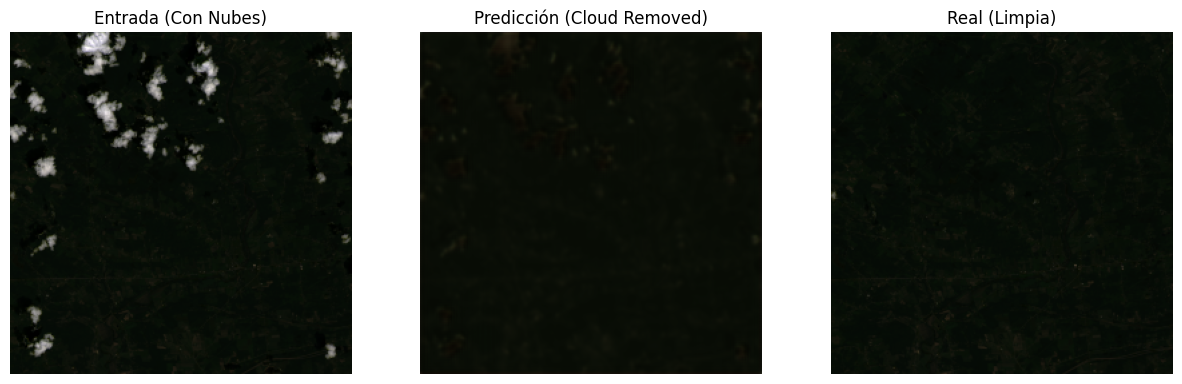

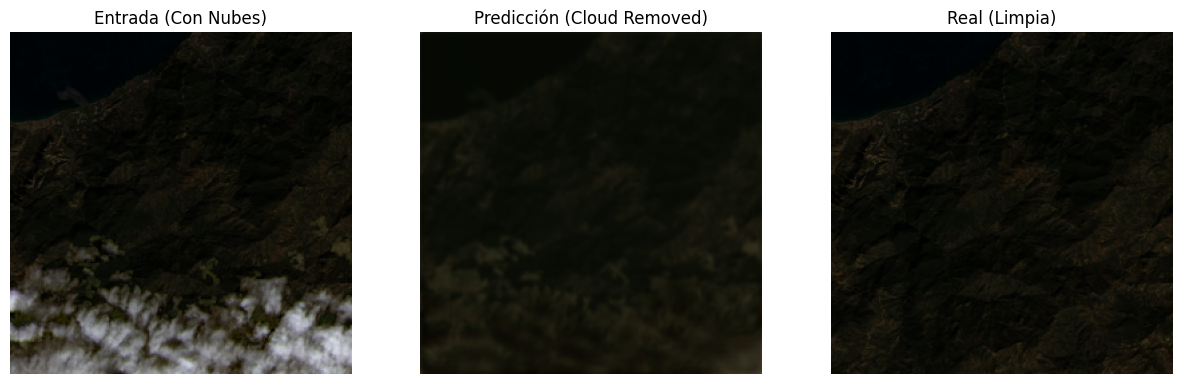

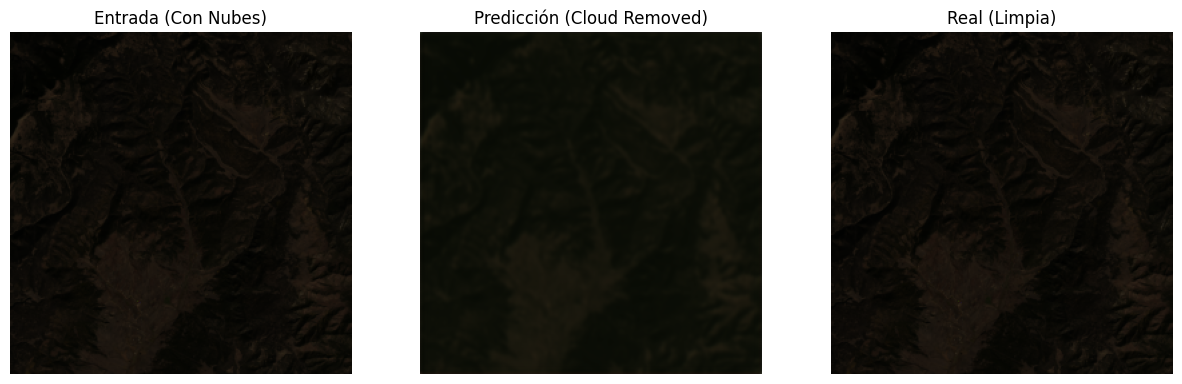


--- Resultados de la Evaluación ---
PSNR Medio: 26.66 dB
SSIM Medio: 0.8042
MAE Medio: 0.0348


In [53]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt

def denormalize(tensor):
    """Pasa de [-1, 1] a [0, 1] para visualización y métricas"""
    return (tensor + 1.0) / 2.0

def evaluate_and_visualize(model, val_loader, device, num_samples=3):
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    mae_metric = torch.nn.L1Loss()
    
    model.eval()
    total_psnr = 0
    total_ssim = 0
    total_mae = 0
    
    samples_shown = 0
    
    print("Iniciando evaluación...")
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            
            output = model(x)
            
            output_dn = denormalize(output)
            y_dn = denormalize(y)
            x_dn = denormalize(x)
            
            total_psnr += psnr_metric(output_dn, y_dn).item()
            total_ssim += ssim_metric(output_dn, y_dn).item()
            total_mae += mae_metric(output_dn, y_dn).item()
            
            if samples_shown < num_samples:
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                
                ax[0].imshow(x_dn[0].cpu().permute(1, 2, 0).numpy().clip(0, 1))
                ax[0].set_title("Entrada (Con Nubes)")
                ax[0].axis('off')
                
                ax[1].imshow(output_dn[0].cpu().permute(1, 2, 0).numpy().clip(0, 1))
                ax[1].set_title("Predicción (Cloud Removed)")
                ax[1].axis('off')
                
                ax[2].imshow(y_dn[0].cpu().permute(1, 2, 0).numpy().clip(0, 1))
                ax[2].set_title("Real (Limpia)")
                ax[2].axis('off')
                
                plt.show()
                samples_shown += 1
                
    avg_psnr = total_psnr / len(val_loader)
    avg_ssim = total_ssim / len(val_loader)
    avg_mae = total_mae / len(val_loader)
    
    print(f"\n--- Resultados de la Evaluación ---")
    print(f"PSNR Medio: {avg_psnr:.2f} dB")
    print(f"SSIM Medio: {avg_ssim:.4f}")
    print(f"MAE Medio: {avg_mae:.4f}")

evaluate_and_visualize(model, val_loader, device)